In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import math
import scipy.stats as ss
import seaborn as sns
import datetime as dt

In [2]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_rep_email from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC' and inc_organisation='QA'"
df = pd.read_sql(query, sql_conn)
df['inc_rep_email'] = df['inc_rep_email'].str.split("@",n=1,expand=True)[0]
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_rep_email
0,2016-03-31,0800,2016-03-31,2025,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,None,None
1,2016-03-31,2100,2016-04-01,1553,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,None
2,2016-04-01,1957,2016-04-01,2002,EMERG,MEDUR,ED,AE,NOHARM,NONE,None,N,N,N,Other,SarahJane.Tafalla
3,2016-03-25,1400,2016-04-01,2126,C7,MEDMED,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),sharon.cooper
4,2016-04-02,0730,2016-04-02,0752,D5,SURMHN,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,manoloriera


In [3]:
df['inc_time'] = df['inc_time'].str.replace(':','')
df['inc_submittedtime'] = df['inc_submittedtime'].str.replace(':','')

In [4]:
df['inc_year'] = df.inc_dincident.dt.year
df['inc_month'] = df.inc_dincident.dt.month
df['inc_day'] = df.inc_dincident.dt.day
df['inc_week'] = df.inc_dincident.dt.week
df['inc_weekday'] = df.inc_dincident.dt.weekday
df['inc_quarter'] = df.inc_dincident.dt.quarter
df['inc_hour'] = df['inc_time'].str[:2]
df['inc_minute'] = df['inc_time'].str[2:4]
df = df.astype({'inc_hour':'int'})
df = df.astype({'inc_minute':'int'})
df['inc_datetime'] = df.apply(lambda x: x.loc['inc_dincident'] + dt.timedelta(hours=x.loc['inc_hour'],minutes=x.loc['inc_minute']), axis=1)
df['reported_year'] = df.inc_dreported.dt.year
df['reported_month'] = df.inc_dreported.dt.month
df['reported_day'] = df.inc_dreported.dt.day
df['reported_week'] = df.inc_dreported.dt.week
df['reported_weekday'] = df.inc_dreported.dt.weekday
df['reported_quarter'] = df.inc_dreported.dt.quarter
df['reported_hour'] = df['inc_submittedtime'].str[:2]
df['reported_minute'] = df['inc_submittedtime'].str[2:4]
df = df.astype({'reported_hour':'int'})
df = df.astype({'reported_minute':'int'})
df['reported_datetime'] = df.apply(lambda x: x.loc['inc_dreported'] + dt.timedelta(hours=x.loc['reported_hour'],minutes=x.loc['reported_minute']), axis=1)
df['diff'] = df['reported_datetime'] - df['inc_datetime']
df['reported-incident'] = df['diff'] / np.timedelta64(1, 'D')
df.head()
df = df.drop(['inc_dincident','inc_time','inc_dreported','inc_submittedtime','inc_datetime','reported_datetime','diff'],axis=1)


In [5]:
def signal_correlations(**kwds):
    
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = df.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(20,18))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title("Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()
    
    c = df.corr()
    s = c.unstack()
    so = s.sort_values(kind="quicksort")

    print(so)
    
    print(df.columns)

reported_month     reported_year       -0.201287
reported_year      reported_month      -0.201287
inc_year           inc_month           -0.201146
inc_month          inc_year            -0.201146
inc_week           inc_year            -0.193942
inc_year           inc_week            -0.193942
inc_month          reported_year       -0.193919
reported_year      inc_month           -0.193919
reported_week      reported_year       -0.193198
reported_year      reported_week       -0.193198
inc_year           reported_month      -0.192401
reported_month     inc_year            -0.192401
inc_week           reported_year       -0.187934
reported_year      inc_week            -0.187934
inc_year           inc_quarter         -0.186987
inc_quarter        inc_year            -0.186987
reported_quarter   reported_year       -0.186042
reported_year      reported_quarter    -0.186042
inc_year           reported_week       -0.184027
reported_week      inc_year            -0.184027
reported_year      i

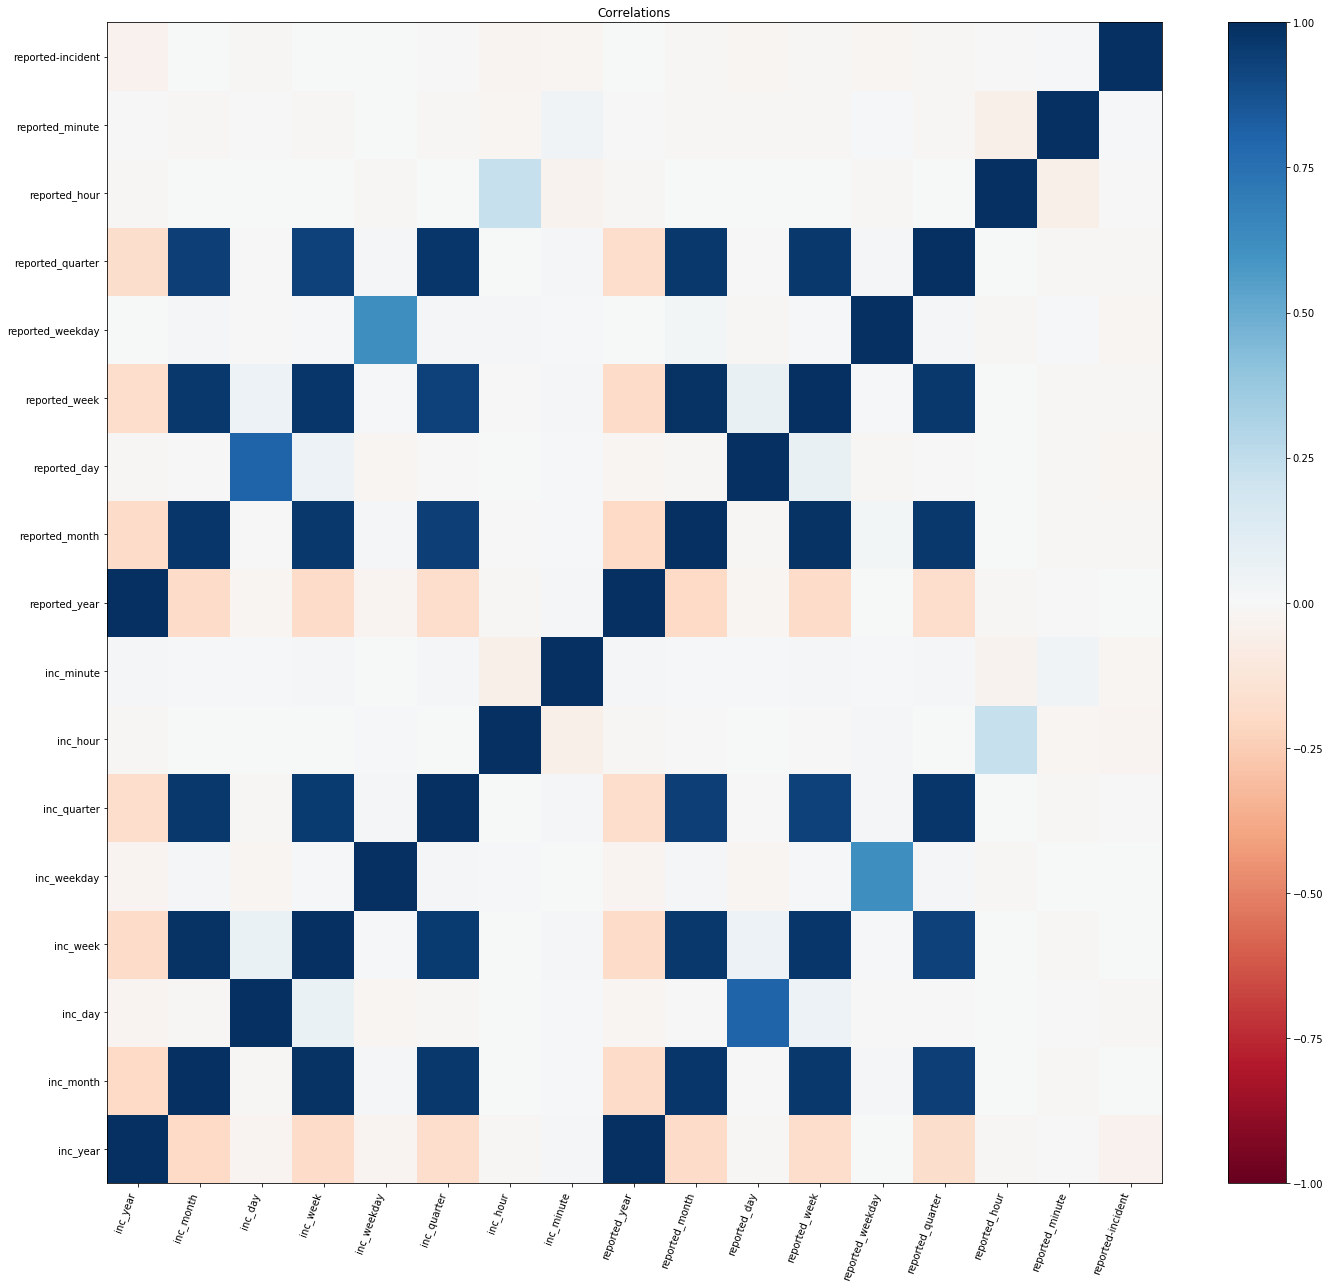

In [6]:
signal_correlations()

In [7]:
def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def correlation_ratio(categories, measurements):
    """
    Calculates the Correlation Ratio (sometimes marked by the greek letter Eta) for categorical-continuous association.
    Answers the question - given a continuous value of a measurement, is it possible to know which category is it
    associated with?
    Value is in the range [0,1], where 0 means a category cannot be determined by a continuous measurement, and 1 means
    a category can be determined with absolute certainty.
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    categories : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    measurements : list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    """
    #categories = convert(categories, 'array')
    #measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     * Pearson's R for continuous-continuous cases
     * Correlation Ratio for categorical-continuous cases
     * Cramer's V or Theil's U for categorical-categorical cases
    **Returns:** a DataFrame of the correlation/strength-of-association between all features
    **Example:** see `associations_example` under `dython.examples`
    Parameters
    ----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    nominal_columns : string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    mark_columns : Boolean, default = False
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    theil_u : Boolean, default = False
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    plot : Boolean, default = True
        If True, plot a heat-map of the correlation matrix
    return_results : Boolean, default = False
        If True, the function will return a Pandas DataFrame of the computed associations
    kwargs : any key-value pairs
        Arguments to be passed to used function and methods
    """
    #dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 0.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=kwargs.get('figsize',None))
        labels = np.round(np.array(corr),decimals=1).astype(str)
        for i in range(0,len(columns)):
            for j in range(i,len(columns)):
                if j>=i: labels[i][j] = ''
        ax = sns.heatmap(corr, annot=labels, fmt='')
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([-0.2, 0, 0.5, 0.9])
        cbar.set_ticklabels(['-0.2 anti-associated', '0 no association', '0.5 associated', '0.9 closely associated'])
        plt.title('Amount of association between variables. 1:fully associated, 0:no association, -1:fully anti-associated')
        plt.show()
    if return_results:
        for i in range(0,len(columns)):
            for j in range(i,len(columns)):
                if j>=i: 
                    corr[columns[i]][columns[j]] = 0.0
        return corr

Index(['ward/dept/unit', 'division&care_group', 'specialty', 'location_type',
       'result', 'severity', 'any_other_patient_involved',
       'any_other_employee_involved', 'any_witness', 'any_document_attached',
       'role', 'email', 'year', 'month', 'day', 'week', 'weekday', 'quarter',
       'hour', 'minute', 'reported_year', 'reported_month', 'reported_day',
       'reported_week', 'reported_weekday', 'reported_quarter',
       'reported_hour', 'reported_minute', 'reported-incident'],
      dtype='object')


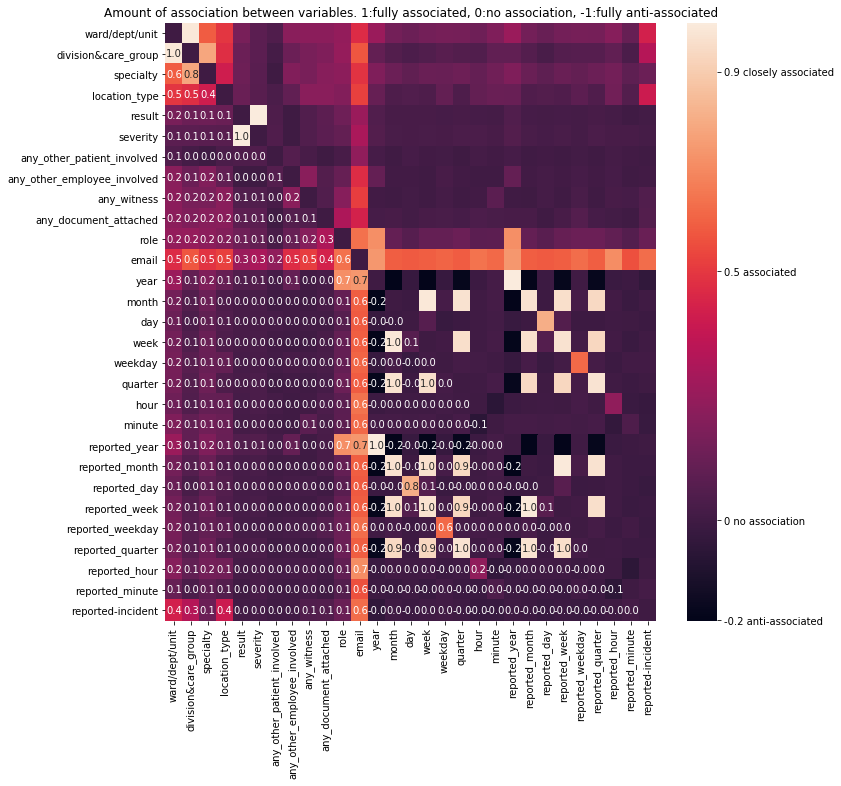

In [8]:
columns_list = df.columns.values
columns_list = [el.replace('_unit','_division&care_group') for el in columns_list]
columns_list = [el.replace('inc_','') for el in columns_list]
columns_list = [el.replace('locactual','ward/dept/unit') for el in columns_list] 
columns_list = [el.replace('loctype','location_type') for el in columns_list]
columns_list = [el.replace('show_other_contacts','any_other_patient_involved') for el in columns_list]
columns_list = [el.replace('show_employee','any_other_employee_involved') for el in columns_list]
columns_list = [el.replace('show_witness','any_witness') for el in columns_list]
columns_list = [el.replace('show_document','any_document_attached') for el in columns_list]
columns_list = [el.replace('rep_email','email') for el in columns_list]
columns_list = [el.replace('reportedby','role') for el in columns_list]
df.columns=columns_list
nominal_columns = df.select_dtypes('O').columns.values
print(df.columns)
associations(df,nominal_columns,figsize=(11,11))

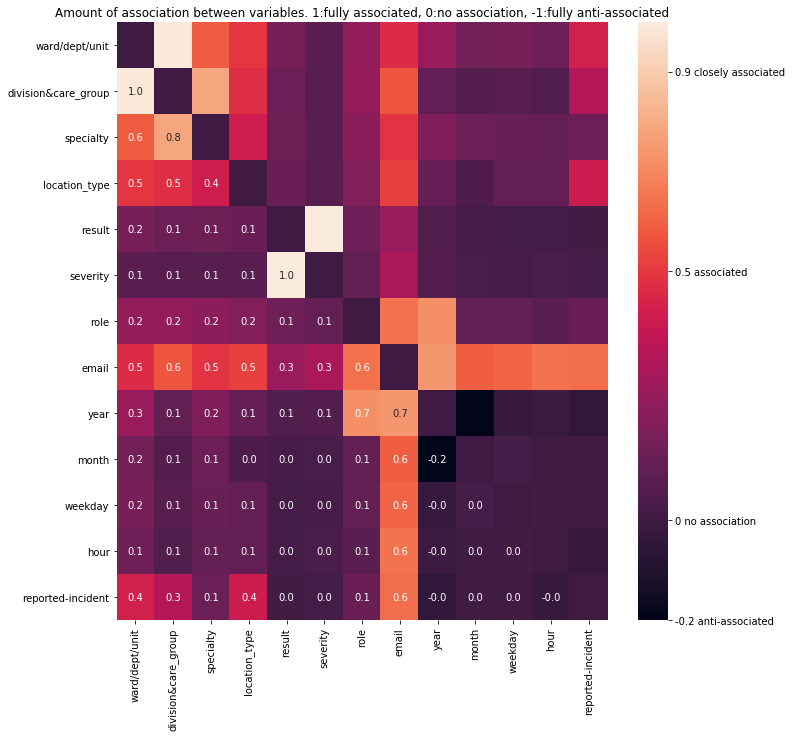

In [20]:
df_new = df.drop(['reported_year','reported_month','reported_day','reported_week','reported_weekday','reported_quarter','reported_hour','reported_minute','day','week','quarter','minute','any_other_patient_involved','any_other_employee_involved','any_witness','any_document_attached'],axis=1)
nominal_columns = df_new.select_dtypes('O').columns.values
returned_results = associations(df_new,nominal_columns,figsize=(11,11),return_results=True)

In [21]:
df_association = pd.DataFrame(columns=['row','col','association','description','interest'])
while returned_results.values.max() > 0.2:
    for row in list(returned_results.index):
        for col in returned_results.columns:
            if returned_results.at[row,col] == returned_results.values.max():
                df_association = df_association.append({'row':row,'col':col,'association':returned_results.values.max()},ignore_index=True)
                returned_results.at[row,col] = 0
                break

In [22]:
df_association = df_association.astype({'description':'object','interest':'object'})

In [23]:
df_association.loc[(df_association['row']=='result') & (df_association['col']=='severity'),'description'] = "both contain options for 'near miss' and 'no harm'"
df_association.loc[(df_association['row']=='result') & (df_association['col']=='severity'),'interest'] = "expected"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='division&care_group'),'description'] = "wards/depts/units are within specific divsions & care groups"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='division&care_group'),'interest'] = "expected"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='specialty'),'description'] = "the fact this isn't 1.0 shows that there are outliers outside of their care group"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='specialty'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='year'),'description'] = "recently, some staff have been reporting more"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='year'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='year'),'description'] = "recently, some roles have been reporting more"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='year'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='hour'),'description'] = "some staff are more likely to see incidents at certain hours"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='hour'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='email'),'description'] = "some staff are in multiple roles"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='email'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='reported-incident'),'description'] = "some staff take longer to report after the incident"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='weekday'),'description'] = "some staff are more likely to see incidents on certain weekdays"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='weekday'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='month'),'description'] = "some staff are more likely to see incidents on certain months"
df_association.loc[(df_association['row']=='email') & (df_association['col']=='month'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='specialty'),'description'] = "the fact this isn't 1.0 shows that there are outliers outside of their ward/dept/unit"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='specialty'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='email'),'description'] = "some divisions & care groups have more staff reporting"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='email'),'interest'] = "expected+interesting"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='email'),'description'] = "some location types have more staff reporting"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='email'),'interest'] = "expected+interesting"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='location_type'),'description'] = "some location types are more likely to be in specific wards/depts/units"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='location_type'),'interest'] = "expected"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='email'),'description'] = "some specialties have more staff reporting"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='email'),'interest'] = "expected+interesting"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='location_type'),'description'] = "some location types are more likely to be in specific divisions & care groups"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='location_type'),'interest'] = "expected"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='email'),'description'] = "some wards/depts/units have more staff reporting"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='email'),'interest'] = "expected+interesting"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='reported-incident'),'description'] = "some wards/depts/units take longer to report after the incident"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='location_type'),'description'] = "some location types are more likely to be in specific specialties"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='location_type'),'interest'] = "expected"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='reported-incident'),'description'] = "some location types take longer to report after the incident"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='reported-incident'),'description'] = "some divisions & care groups take longer to report after the incident"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='severity') & (df_association['col']=='email'),'description'] = "some staff see more severe incidents"
df_association.loc[(df_association['row']=='severity') & (df_association['col']=='email'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='year'),'description'] = "some staff see incidents with specific results"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='year'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='result') & (df_association['col']=='email'),'description'] = "recently, some wards/depts/units have had more incidents"
df_association.loc[(df_association['row']=='result') & (df_association['col']=='email'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='role'),'description'] = "some roles see incidents in specific divisions & care groups"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='role'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='role'),'description'] = "some roles see incidents in specific wards/depts/units"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='role'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='role'),'description'] = "some roles see incidents in specific specialties"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='role'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='role'),'description'] = "some roles see incidents in specific location types"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='role'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='year'),'description'] = "recently, some specialties have had more incidents"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='year'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='result'),'description'] = "some wards/depts/units see incidents with specific results"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='result'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='weekday'),'description'] = "some wards/depts/units see incidents on specific weekdays"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='weekday'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='month'),'description'] = "some wards/depts/units see incidents in specific months"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='month'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='hour'),'description'] = "some wards/depts/units see incidents during specific hours"
df_association.loc[(df_association['row']=='ward/dept/unit') & (df_association['col']=='hour'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='result') & (df_association['col']=='role'),'description'] = "some roles see incidents with specific results"
df_association.loc[(df_association['row']=='result') & (df_association['col']=='role'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='result'),'description'] = "some specialties see incidents with specific results"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='result'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='result'),'description'] = "some divisions & care groups see incidents with specific results"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='result'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='reported-incident'),'description'] = "some specialties take longer to report after the incident"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='result'),'description'] = "some specialties see incidents in specific months"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='result'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='reported-incident'),'description'] = "some roles take longer to report after the incident"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='reported-incident'),'interest'] = "interesting"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='month'),'description'] = "some locationt types see incidents with specific results"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='month'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='weekday'),'description'] = "some specialties see incidents on specific weekdays"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='weekday'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='year'),'description'] = "recently, some location types have had more incidents"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='year'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='hour'),'description'] = "some specialties see incidents during specific hours"
df_association.loc[(df_association['row']=='specialty') & (df_association['col']=='hour'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='weekday'),'description'] = "some roles see incidents on specific weekdays"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='weekday'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='weekday'),'description'] = "some location types see incidents on specific weekdays"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='weekday'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='hour'),'description'] = "some location types see incidents during specific hours"
df_association.loc[(df_association['row']=='location_type') & (df_association['col']=='hour'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='month'),'description'] = "some roles see incidents in specific months"
df_association.loc[(df_association['row']=='role') & (df_association['col']=='month'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='year'),'description'] = "recently, some divisions & care groups have had more incidents"
df_association.loc[(df_association['row']=='division&care_group') & (df_association['col']=='year'),'interest'] = "interesting?"
df_association.loc[(df_association['row']=='severity') & (df_association['col']=='role'),'description'] = "some roles see more severe incidents"
df_association.loc[(df_association['row']=='severity') & (df_association['col']=='role'),'interest'] = "interesting"

In [24]:
print(df_association)

                    row                  col  association  \
0                result             severity     0.998857   
1        ward/dept/unit  division&care_group     0.988486   
2   division&care_group            specialty     0.785106   
3                 email                 year     0.744744   
4                  role                 year     0.719374   
5                 email                 hour     0.643476   
6                  role                email     0.639399   
7                 email    reported-incident     0.630631   
8                 email              weekday     0.607626   
9                 email                month     0.592935   
10       ward/dept/unit            specialty     0.590624   
11  division&care_group                email     0.575865   
12        location_type                email     0.524656   
13       ward/dept/unit        location_type     0.492702   
14            specialty                email     0.483827   
15  division&care_group 

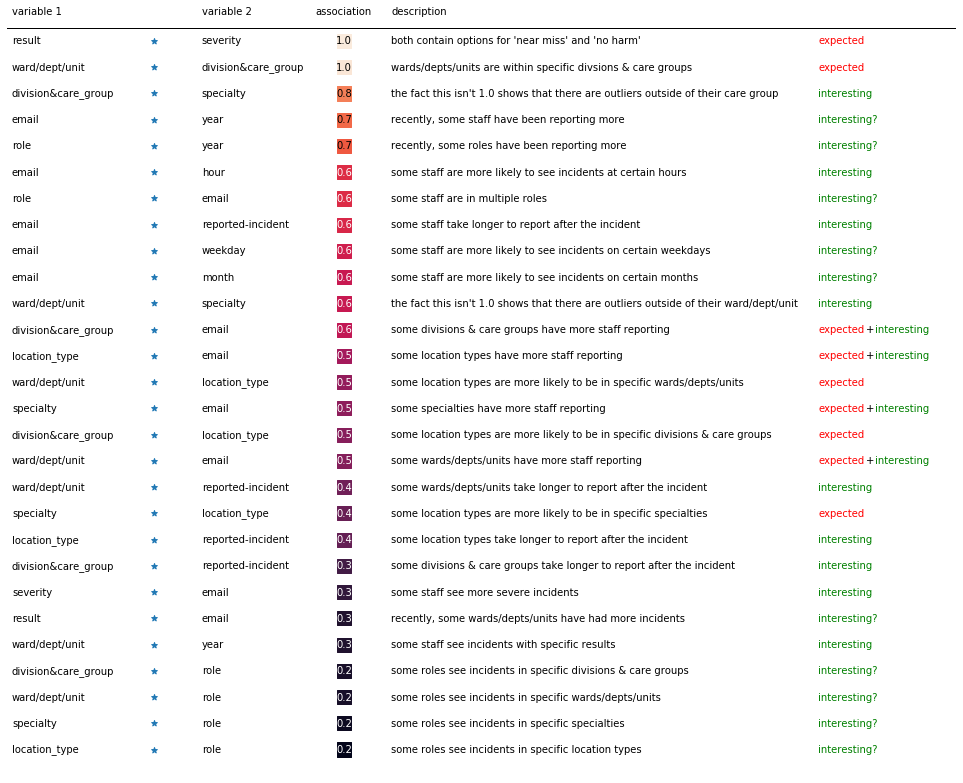

In [59]:
cm = sns.cm.rocket
color = df_association['association']
size = np.ones(len(df_association))*200
plt.figure(figsize=(17,14))
plt.ylim(df_association.index.max()+1,-1)
plt.xlim(0.29,2.29)
plt.scatter(np.ones(len(df_association)),df_association.index,marker='s',c=color,cmap=cm,s=size)
plt.scatter(np.ones(len(df_association))*0.6,df_association.index,marker='*')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
for i in df_association.index:
    number_color = 'w' if df_association.at[i,'association']<0.66 else 'k'
    plt.text(0.3,i,df_association.at[i,'row'],ha='left',va='center')
    plt.text(0.7,i,df_association.at[i,'col'],ha='left',va='center')
    plt.text(1,i,round(df_association.at[i,'association'],1),ha='center',va='center',color=number_color)
    plt.text(1.1,i,df_association.at[i,'description'],ha='left',va='center')
    interest_color = 'r' if df_association.at[i,'interest']=='expected' else 'g'
    interest_start = 2.0
    if 'expected' in df_association.at[i,'interest']:
        plt.text(2.0,i,'expected',ha='left',va='center',color='r')
    if '+' in df_association.at[i,'interest']:
        plt.text(2.1,i,'+',ha='left',va='center')
        interest_start = 2.12
    if 'interesting' in df_association.at[i,'interest']:
        plt.text(interest_start,i,df_association.at[i,'interest'].strip('expected+'),ha='left',va='center',color='g')
    #plt.axhline(i+0.5,color='k',linewidth=1)
plt.gca().axis('off')
plt.text(0.3,-1,'variable 1')
plt.text(0.7,-1,'variable 2')
plt.text(1,-1,'association',ha='center')
plt.text(1.1,-1,'description');
plt.axhline(-0.5,color='k',linewidth=1);
plt.savefig('association_table.png')
plt.savefig('association_table.pdf')